In [1]:
import os
import lightgbm as lgb
import pandas as pd
import warnings
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import datetime
import optuna
import random
from datetime import datetime
import pytz

# importo los .py
import sys
sys.path.append("auxiliares")
import config
import metricas
import lightgbm_aux
import extras

pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_columns', None)

# Ignore all warnings
warnings.filterwarnings("ignore")

In [2]:
####################################################
############# Setear segun cada maquina ############
#os.chdir("C:/Users/herna/labo3_empresa3_repo/")
#os.chdir("C:/diego_tools/labo3/")
os.chdir("/home/dcastro_contacto/buckets/b1/")
####################################################

In [3]:
arch_entrada = "datasets/emp3_sellout_fe_estrellas.csv"
carpeta_base_exp = "exp/estrella/"

In [4]:
def lgbm_error_rate(preds, train_data):
    labels = train_data.get_label()
    ret_val = metricas.error_rate(labels,preds)
    return 'ER', ret_val, False

In [5]:
def objective(trial):
    print("****************", config.OBJECTIVE_PARAM, "****************")
    
    lgb_params = {
        'objective': config.OBJECTIVE_PARAM,
        'first_metric_only': True,
        'boost_from_average': True,
        'max_depth':-1,
        'lambda_l1': trial.suggest_uniform('lambda_l1', 0.0,config.L1_UPPER_PARAM),
        'lambda_l2': trial.suggest_uniform('lambda_l2', 0.0,config.L2_UPPER_PARAM),
        'min_gain_to_split':0.0,
        'force_row_wise':True,
        'feature_pre_filter':False,
        'metric': "None",
        'max_bin': config.MAX_BIN_PARAM,
        'learning_rate': trial.suggest_uniform('learning_rate', config.LEARNING_RATE_LOWER_PARAM,config.LEARNING_RATE_UPPER_PARAM ),
        'num_leaves' : trial.suggest_int('num_leaves', config.NUM_LEAVES_LOWER_PARAM, config.NUM_LEAVES_UPPER_PARAM),
        'feature_fraction': trial.suggest_uniform('feature_fraction', config.FEATURE_FRACTION_LOWER_PARAM, config.FEATURE_FRACTION_UPPER_PARAM),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', config.MIN_DATA_IN_LEAF_LOWER_PARAM, config.MIN_DATA_IN_LEAF_UPPER_PARAM),
        #'bagging_freq':trial.suggest_int('bagging_freq', 1, 10),
        #'bagging_fraction': trial.suggest_categorical('bagging_fraction',[0.7,0.75,0.8,0.85,0.9,0.95]),
        #'extra_trees':trial.suggest_categorical('extra_trees',[True,False]),
        'verbose':-100,
        'num_threads':-1
    }
    
    lgb_params_num_boost_round = 10000  #un numero muy grande, lo limita early_stopping_rounds
    lgb_params_early_stopping_rounds = int(50 + 5/lgb_params['learning_rate']) #  #el parametro discolo, que depende de otro
    
    lgb_train = lgb.Dataset(data=X_train, label=y_train, feature_name=cols_entren)
    lgb_validate = lgb.Dataset(data=X_validate, label=y_validate, reference=lgb_train, feature_name=cols_entren)
    
    #Train using selected parameters
    model = lgb.train(lgb_params, lgb_train,
                  valid_sets=[lgb_validate],
                  num_boost_round=lgb_params_num_boost_round,
                  early_stopping_rounds=lgb_params_early_stopping_rounds,
                  feval=lgbm_error_rate,
                  verbose_eval=100)
    
    y_pred_validate =model.predict(X_validate) #Create predictions on test set
    er_validate = metricas.error_rate(y_validate,y_pred_validate)
    
    GLOBAL_PARAMS_ITER.append(lgb_params)
    GLOBAL_BEST_IT_ITER.append(model.best_iteration)
    GLOBAL_ER_VALIDATE_ITER.append(er_validate)
    GLOBAL_MODEL_ITER.append(model)
    
    return er_validate

In [6]:
##############################################

In [7]:
df_sellout = pd.read_csv(arch_entrada)
df_sellout.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Columns: 558 entries, product_id to cat3_tn_bollinger_band_lower_15
dtypes: bool(1), float64(543), int64(8), object(6)
memory usage: 16.6+ MB


In [8]:
### Categoricas
df_sellout = extras.convertir_categoricas_prod_cust(df_sellout)

df_sellout = df_sellout.drop(columns=["periodo_fecha","brand"])

In [9]:
### Split de datasets
df_train = df_sellout[(df_sellout.periodo <= config.TRAIN_PERIODO_LIMITE_PARAM) & (df_sellout.periodo >= config.PERIODO_INICIO_PARAM)]
df_validate = df_sellout[(df_sellout.periodo == config.VALIDATE_PERIODO_PARAM)]

print("Periodos entrenar:",df_train.periodo.unique())
print("Periodos validar:",df_validate.periodo.unique())

df_validate = df_validate.sort_values(by="prod_cust",ascending=True)
print("prod_cust a validar:", len(df_validate))

Periodos entrenar: [201701 201702 201703 201704 201705 201706 201707 201708 201709 201710
 201711 201712 201801 201802 201803 201804 201805 201806 201807 201808
 201809 201810 201811 201812 201901 201902 201903 201904 201905]
Periodos validar: [201907]
prod_cust a validar: 120


In [10]:
### Armado variables entrenamiento
cols_remover_entren = ["tn_mas_2","periodo"]

# Train - Validate
X_train = df_train.drop(columns=cols_remover_entren, axis=1)
X_validate = df_validate.drop(columns=cols_remover_entren, axis=1)

y_train = df_train.tn_mas_2
y_validate = df_validate.tn_mas_2

print("X_train:", X_train.shape)
print("y_train:", y_train.shape)

print("\nX_validate:", X_validate.shape)
print("y_validate:", y_validate.shape)

cols_entren = X_train.columns.tolist()

X_train: (3180, 554)
y_train: (3180,)

X_validate: (120, 554)
y_validate: (120,)


In [11]:
### Optimizacion Bayesiana
GLOBAL_PARAMS_ITER = []
GLOBAL_BEST_IT_ITER = []
GLOBAL_ER_VALIDATE_ITER = []
GLOBAL_MODEL_ITER = []

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=config.CANT_ITERACIONES_OPT_BAY_PARAM)
print('# Experimentos:', len(study.trials))
print('Mejor experimento:', study.best_trial.params)

[I 2023-12-12 23:12:03,897] A new study created in memory with name: no-name-ceb5e069-c640-4953-a08f-f4fb4cabe1d4


**************** regression ****************


[I 2023-12-12 23:12:04,166] Trial 0 finished with value: 102.6 and parameters: {'lambda_l1': 160.03583880133775, 'lambda_l2': 33.12890628363419, 'learning_rate': 0.04803582300588792, 'num_leaves': 226, 'feature_fraction': 0.8698161366988086, 'min_data_in_leaf': 2584}. Best is trial 0 with value: 102.6.


Training until validation scores don't improve for 154 rounds
[100]	valid_0's ER: 166.18
Early stopping, best iteration is:
[1]	valid_0's ER: 166.18
Evaluated only: ER
**************** regression ****************


[I 2023-12-12 23:12:04,383] Trial 1 finished with value: 102.6 and parameters: {'lambda_l1': 301.20308037030486, 'lambda_l2': 535.3402769381805, 'learning_rate': 0.10409349377104656, 'num_leaves': 362, 'feature_fraction': 0.6962425253200981, 'min_data_in_leaf': 2367}. Best is trial 0 with value: 102.6.


Training until validation scores don't improve for 98 rounds
Early stopping, best iteration is:
[1]	valid_0's ER: 166.18
Evaluated only: ER
**************** regression ****************
Training until validation scores don't improve for 73 rounds
[100]	valid_0's ER: 78.28
[200]	valid_0's ER: 76.44


[I 2023-12-12 23:12:05,379] Trial 2 finished with value: 75.67 and parameters: {'lambda_l1': 669.3144569822738, 'lambda_l2': 474.42391728853084, 'learning_rate': 0.20939275097578214, 'num_leaves': 503, 'feature_fraction': 0.49922252387895194, 'min_data_in_leaf': 980}. Best is trial 2 with value: 75.67.


[300]	valid_0's ER: 76.46
Early stopping, best iteration is:
[247]	valid_0's ER: 75.67
Evaluated only: ER
**************** regression ****************


[I 2023-12-12 23:12:05,630] Trial 3 finished with value: 102.6 and parameters: {'lambda_l1': 874.5178008261867, 'lambda_l2': 681.4052937824212, 'learning_rate': 0.10218442398104721, 'num_leaves': 72, 'feature_fraction': 0.417133136360036, 'min_data_in_leaf': 2208}. Best is trial 2 with value: 75.67.


Training until validation scores don't improve for 98 rounds
Early stopping, best iteration is:
[1]	valid_0's ER: 166.18
Evaluated only: ER
**************** regression ****************


[I 2023-12-12 23:12:05,961] Trial 4 finished with value: 102.6 and parameters: {'lambda_l1': 302.56018619048643, 'lambda_l2': 683.0236801412095, 'learning_rate': 0.05721020445179794, 'num_leaves': 866, 'feature_fraction': 0.8613266157240675, 'min_data_in_leaf': 3807}. Best is trial 2 with value: 75.67.


Training until validation scores don't improve for 137 rounds
[100]	valid_0's ER: 166.18
Early stopping, best iteration is:
[1]	valid_0's ER: 166.18
Evaluated only: ER
**************** regression ****************
Training until validation scores don't improve for 72 rounds
[100]	valid_0's ER: 58.01
[200]	valid_0's ER: 56.93


[I 2023-12-12 23:12:06,674] Trial 5 finished with value: 56.49 and parameters: {'lambda_l1': 970.4170742820532, 'lambda_l2': 916.4787929941219, 'learning_rate': 0.21795868484561867, 'num_leaves': 62, 'feature_fraction': 0.20251727239723527, 'min_data_in_leaf': 469}. Best is trial 5 with value: 56.49.


[300]	valid_0's ER: 56.74
Early stopping, best iteration is:
[254]	valid_0's ER: 56.49
Evaluated only: ER
**************** regression ****************


[I 2023-12-12 23:12:07,010] Trial 6 finished with value: 102.6 and parameters: {'lambda_l1': 75.18314836835071, 'lambda_l2': 877.4612186671183, 'learning_rate': 0.1288028280912511, 'num_leaves': 543, 'feature_fraction': 0.5220668881024828, 'min_data_in_leaf': 2299}. Best is trial 5 with value: 56.49.


Training until validation scores don't improve for 88 rounds
Early stopping, best iteration is:
[1]	valid_0's ER: 166.18
Evaluated only: ER
**************** regression ****************
Training until validation scores don't improve for 94 rounds
[100]	valid_0's ER: 83.72
[200]	valid_0's ER: 81.48
[300]	valid_0's ER: 80.46
[400]	valid_0's ER: 79.21
[500]	valid_0's ER: 78.33
[600]	valid_0's ER: 77.94


[I 2023-12-12 23:12:08,632] Trial 7 finished with value: 77.83 and parameters: {'lambda_l1': 307.2201669517086, 'lambda_l2': 992.9857323860091, 'learning_rate': 0.11139629442841491, 'num_leaves': 481, 'feature_fraction': 0.8179370609037522, 'min_data_in_leaf': 1086}. Best is trial 5 with value: 56.49.


[700]	valid_0's ER: 78.01
Early stopping, best iteration is:
[625]	valid_0's ER: 77.83
Evaluated only: ER
**************** regression ****************


[I 2023-12-12 23:12:08,961] Trial 8 finished with value: 102.6 and parameters: {'lambda_l1': 906.7993388545385, 'lambda_l2': 557.9965642309546, 'learning_rate': 0.12247931485496429, 'num_leaves': 706, 'feature_fraction': 0.5116737960978661, 'min_data_in_leaf': 3867}. Best is trial 5 with value: 56.49.


Training until validation scores don't improve for 90 rounds
Early stopping, best iteration is:
[1]	valid_0's ER: 166.18
Evaluated only: ER
**************** regression ****************
Training until validation scores don't improve for 131 rounds
[100]	valid_0's ER: 86.17
[200]	valid_0's ER: 82.54
[300]	valid_0's ER: 81.41
[400]	valid_0's ER: 80.55
[500]	valid_0's ER: 79.8
[600]	valid_0's ER: 79.27
[700]	valid_0's ER: 78.86
[800]	valid_0's ER: 78.58
[900]	valid_0's ER: 78.43
[1000]	valid_0's ER: 78.27
[1100]	valid_0's ER: 78.21
[1200]	valid_0's ER: 78.13
[1300]	valid_0's ER: 78
[1400]	valid_0's ER: 78
Early stopping, best iteration is:
[1358]	valid_0's ER: 77.96
Evaluated only: ER


[I 2023-12-12 23:12:11,884] Trial 9 finished with value: 77.96 and parameters: {'lambda_l1': 743.5719608160732, 'lambda_l2': 846.4383297174121, 'learning_rate': 0.061299990600752446, 'num_leaves': 430, 'feature_fraction': 0.7956019608047715, 'min_data_in_leaf': 1393}. Best is trial 5 with value: 56.49.


**************** regression ****************
Training until validation scores don't improve for 67 rounds


[I 2023-12-12 23:12:12,103] Trial 10 finished with value: 102.6 and parameters: {'lambda_l1': 994.8696549811773, 'lambda_l2': 946.7534344199554, 'learning_rate': 0.28061159546438197, 'num_leaves': 36, 'feature_fraction': 0.203230801842392, 'min_data_in_leaf': 7398}. Best is trial 5 with value: 56.49.


Early stopping, best iteration is:
[1]	valid_0's ER: 166.18
Evaluated only: ER
**************** regression ****************
Training until validation scores don't improve for 74 rounds
[100]	valid_0's ER: 58.34


[I 2023-12-12 23:12:13,383] Trial 11 finished with value: 58.15 and parameters: {'lambda_l1': 658.6707644869316, 'lambda_l2': 331.5424443846109, 'learning_rate': 0.2004502317747021, 'num_leaves': 998, 'feature_fraction': 0.22931883499355368, 'min_data_in_leaf': 44}. Best is trial 5 with value: 56.49.


Early stopping, best iteration is:
[103]	valid_0's ER: 58.15
Evaluated only: ER
**************** regression ****************
Training until validation scores don't improve for 77 rounds
[100]	valid_0's ER: 59.87
[200]	valid_0's ER: 58.68


[I 2023-12-12 23:12:15,602] Trial 12 finished with value: 58.3 and parameters: {'lambda_l1': 583.6695541647845, 'lambda_l2': 350.8753935047945, 'learning_rate': 0.17947234936646975, 'num_leaves': 1004, 'feature_fraction': 0.21126159879222517, 'min_data_in_leaf': 8}. Best is trial 5 with value: 56.49.


Early stopping, best iteration is:
[219]	valid_0's ER: 58.3
Evaluated only: ER
**************** regression ****************


[I 2023-12-12 23:12:15,879] Trial 13 finished with value: 102.6 and parameters: {'lambda_l1': 784.2557500022377, 'lambda_l2': 295.3488810029652, 'learning_rate': 0.22619910869245421, 'num_leaves': 731, 'feature_fraction': 0.2960684017100951, 'min_data_in_leaf': 6057}. Best is trial 5 with value: 56.49.


Training until validation scores don't improve for 72 rounds
Early stopping, best iteration is:
[1]	valid_0's ER: 166.18
Evaluated only: ER
**************** regression ****************


[I 2023-12-12 23:12:16,133] Trial 14 finished with value: 102.6 and parameters: {'lambda_l1': 524.2486837673114, 'lambda_l2': 750.5104960019341, 'learning_rate': 0.24070319647335958, 'num_leaves': 224, 'feature_fraction': 0.344195281890747, 'min_data_in_leaf': 5263}. Best is trial 5 with value: 56.49.


Training until validation scores don't improve for 70 rounds
Early stopping, best iteration is:
[1]	valid_0's ER: 166.18
Evaluated only: ER
**************** regression ****************
Training until validation scores don't improve for 78 rounds
[100]	valid_0's ER: 56.41
[200]	valid_0's ER: 55.83


[I 2023-12-12 23:12:17,473] Trial 15 finished with value: 54.99 and parameters: {'lambda_l1': 998.3732312515276, 'lambda_l2': 807.2695926740516, 'learning_rate': 0.17746463893603295, 'num_leaves': 682, 'feature_fraction': 0.3289131487557503, 'min_data_in_leaf': 243}. Best is trial 15 with value: 54.99.


[300]	valid_0's ER: 55.33
Early stopping, best iteration is:
[254]	valid_0's ER: 54.99
Evaluated only: ER
**************** regression ****************
Training until validation scores don't improve for 80 rounds
[100]	valid_0's ER: 58.35
[200]	valid_0's ER: 57.45
Early stopping, best iteration is:
[178]	valid_0's ER: 57.2
Evaluated only: ER


[I 2023-12-12 23:12:18,387] Trial 16 finished with value: 57.2 and parameters: {'lambda_l1': 934.7865629758234, 'lambda_l2': 812.9497812671045, 'learning_rate': 0.16365784326609656, 'num_leaves': 685, 'feature_fraction': 0.3653270725999047, 'min_data_in_leaf': 573}. Best is trial 15 with value: 54.99.


**************** regression ****************


[I 2023-12-12 23:12:18,631] Trial 17 finished with value: 102.6 and parameters: {'lambda_l1': 995.3046560436909, 'lambda_l2': 998.9495020727812, 'learning_rate': 0.2631999118475615, 'num_leaves': 603, 'feature_fraction': 0.9961688563859521, 'min_data_in_leaf': 5039}. Best is trial 15 with value: 54.99.


Training until validation scores don't improve for 68 rounds
Early stopping, best iteration is:
[1]	valid_0's ER: 166.18
Evaluated only: ER
**************** regression ****************


[I 2023-12-12 23:12:18,891] Trial 18 finished with value: 102.6 and parameters: {'lambda_l1': 813.8482166223367, 'lambda_l2': 893.752398969538, 'learning_rate': 0.18414053084627452, 'num_leaves': 276, 'feature_fraction': 0.2849030360939739, 'min_data_in_leaf': 3287}. Best is trial 15 with value: 54.99.


Training until validation scores don't improve for 77 rounds
Early stopping, best iteration is:
[1]	valid_0's ER: 166.18
Evaluated only: ER
**************** regression ****************
Training until validation scores don't improve for 67 rounds
[100]	valid_0's ER: 81.17
[200]	valid_0's ER: 79.76
[300]	valid_0's ER: 79.09


[I 2023-12-12 23:12:19,744] Trial 19 finished with value: 79.0 and parameters: {'lambda_l1': 857.254123083504, 'lambda_l2': 769.3460358413977, 'learning_rate': 0.290923758185508, 'num_leaves': 885, 'feature_fraction': 0.41604058209634587, 'min_data_in_leaf': 1414}. Best is trial 15 with value: 54.99.


Early stopping, best iteration is:
[271]	valid_0's ER: 79
Evaluated only: ER
**************** regression ****************


[I 2023-12-12 23:12:19,982] Trial 20 finished with value: 102.6 and parameters: {'lambda_l1': 996.8510862549463, 'lambda_l2': 911.3347471635152, 'learning_rate': 0.1529132232262881, 'num_leaves': 132, 'feature_fraction': 0.2914836174560562, 'min_data_in_leaf': 7231}. Best is trial 15 with value: 54.99.


Training until validation scores don't improve for 82 rounds
Early stopping, best iteration is:
[1]	valid_0's ER: 166.18
Evaluated only: ER
**************** regression ****************
Training until validation scores don't improve for 80 rounds
[100]	valid_0's ER: 58.28


[I 2023-12-12 23:12:20,833] Trial 21 finished with value: 57.68 and parameters: {'lambda_l1': 908.4947723897317, 'lambda_l2': 805.3157916764368, 'learning_rate': 0.16231141007889693, 'num_leaves': 680, 'feature_fraction': 0.37105413886832106, 'min_data_in_leaf': 549}. Best is trial 15 with value: 54.99.


[200]	valid_0's ER: 57.94
Early stopping, best iteration is:
[182]	valid_0's ER: 57.68
Evaluated only: ER
**************** regression ****************
Training until validation scores don't improve for 71 rounds


[I 2023-12-12 23:12:21,457] Trial 22 finished with value: 56.57 and parameters: {'lambda_l1': 745.6518696110014, 'lambda_l2': 841.0757416547463, 'learning_rate': 0.23687388126165165, 'num_leaves': 805, 'feature_fraction': 0.38352314416792216, 'min_data_in_leaf': 582}. Best is trial 15 with value: 54.99.


[100]	valid_0's ER: 56.71
Early stopping, best iteration is:
[85]	valid_0's ER: 56.57
Evaluated only: ER
**************** regression ****************


[I 2023-12-12 23:12:21,755] Trial 23 finished with value: 102.6 and parameters: {'lambda_l1': 779.011626693527, 'lambda_l2': 923.190928989034, 'learning_rate': 0.24014811306872308, 'num_leaves': 816, 'feature_fraction': 0.436995295416705, 'min_data_in_leaf': 1623}. Best is trial 15 with value: 54.99.


Training until validation scores don't improve for 70 rounds
Early stopping, best iteration is:
[1]	valid_0's ER: 166.18
Evaluated only: ER
**************** regression ****************
Training until validation scores don't improve for 69 rounds
[100]	valid_0's ER: 56.46


[I 2023-12-12 23:12:22,499] Trial 24 finished with value: 55.36 and parameters: {'lambda_l1': 843.8783098867555, 'lambda_l2': 711.5312627710161, 'learning_rate': 0.2584665943274046, 'num_leaves': 614, 'feature_fraction': 0.2982373411723681, 'min_data_in_leaf': 491}. Best is trial 15 with value: 54.99.


[200]	valid_0's ER: 55.56
Early stopping, best iteration is:
[175]	valid_0's ER: 55.36
Evaluated only: ER
**************** regression ****************


[I 2023-12-12 23:12:22,773] Trial 25 finished with value: 102.6 and parameters: {'lambda_l1': 850.0718506283, 'lambda_l2': 704.975680932869, 'learning_rate': 0.2607990628661049, 'num_leaves': 615, 'feature_fraction': 0.272177755628752, 'min_data_in_leaf': 1773}. Best is trial 15 with value: 54.99.


Training until validation scores don't improve for 69 rounds
Early stopping, best iteration is:
[1]	valid_0's ER: 166.18
Evaluated only: ER
**************** regression ****************


[I 2023-12-12 23:12:23,029] Trial 26 finished with value: 102.6 and parameters: {'lambda_l1': 940.9307912308004, 'lambda_l2': 749.4412706400009, 'learning_rate': 0.2137460138235401, 'num_leaves': 363, 'feature_fraction': 0.24090837799937037, 'min_data_in_leaf': 2909}. Best is trial 15 with value: 54.99.


Training until validation scores don't improve for 73 rounds
Early stopping, best iteration is:
[1]	valid_0's ER: 166.18
Evaluated only: ER
**************** regression ****************
Training until validation scores don't improve for 74 rounds
[100]	valid_0's ER: 58.24


[I 2023-12-12 23:12:23,694] Trial 27 finished with value: 57.03 and parameters: {'lambda_l1': 826.1672316163983, 'lambda_l2': 638.9058147402496, 'learning_rate': 0.20073270529155945, 'num_leaves': 584, 'feature_fraction': 0.31064481942560485, 'min_data_in_leaf': 672}. Best is trial 15 with value: 54.99.


[200]	valid_0's ER: 57.49
Early stopping, best iteration is:
[156]	valid_0's ER: 57.03
Evaluated only: ER
**************** regression ****************
Training until validation scores don't improve for 68 rounds
[100]	valid_0's ER: 59.07
[200]	valid_0's ER: 57.91
Early stopping, best iteration is:
[210]	valid_0's ER: 57.77
Evaluated only: ER


[I 2023-12-12 23:12:24,583] Trial 28 finished with value: 57.77 and parameters: {'lambda_l1': 921.8326243224759, 'lambda_l2': 836.1929422711612, 'learning_rate': 0.26806420895988187, 'num_leaves': 435, 'feature_fraction': 0.20238999380506473, 'min_data_in_leaf': 184}. Best is trial 15 with value: 54.99.


**************** regression ****************
Training until validation scores don't improve for 69 rounds


[I 2023-12-12 23:12:24,825] Trial 29 finished with value: 102.6 and parameters: {'lambda_l1': 857.0088817692176, 'lambda_l2': 625.2888048904309, 'learning_rate': 0.25475919055390633, 'num_leaves': 186, 'feature_fraction': 0.3364538900815934, 'min_data_in_leaf': 3010}. Best is trial 15 with value: 54.99.


Early stopping, best iteration is:
[1]	valid_0's ER: 166.18
Evaluated only: ER
# Experimentos: 30
Mejor experimento: {'lambda_l1': 998.3732312515276, 'lambda_l2': 807.2695926740516, 'learning_rate': 0.17746463893603295, 'num_leaves': 682, 'feature_fraction': 0.3289131487557503, 'min_data_in_leaf': 243}


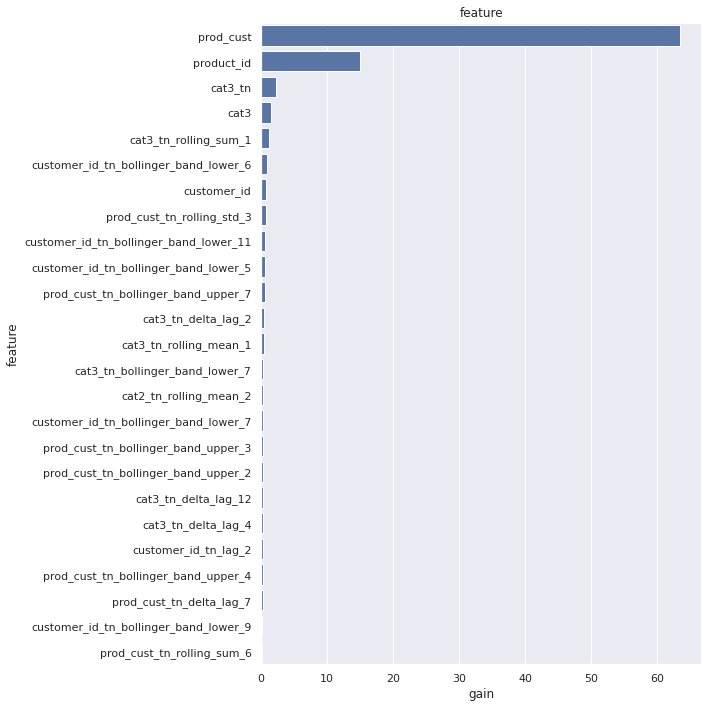

In [12]:
# Feature Importance
best_model_index = study.best_trial.number
best_model = GLOBAL_MODEL_ITER[best_model_index]
feature_importance = lightgbm_aux.plot_lgb_importances(best_model, num=30, plot=True)

In [13]:
#Si se usa holdout, se generan variables para luego evaluar modelos
if(config.USAR_HOLDOUT_PARAM):
    # Dataframes
    df_train_all = df_sellout[(df_sellout.periodo <= config.TRAIN_ALL_PERIODO_LIMITE_PARAM) & (df_sellout.periodo >= config.PERIODO_INICIO_PARAM)]
    df_holdout = df_sellout[(df_sellout.periodo == config.HOLDOUT_PERIODO_PARAM)]
    
    df_holdout = df_holdout.sort_values(by="prod_cust",ascending=True)
    print("prod_cust a testear:", len(df_holdout))

    print("Periodos entrenar ALL:",df_train_all.periodo.unique())
    print("Periodos holdout:",df_holdout.periodo.unique())

    # Variables entrenamiento
    X_train_all = df_train_all.drop(columns=cols_remover_entren, axis=1)
    X_holdout = df_holdout.drop(columns=cols_remover_entren, axis=1)
    
    y_train_all = df_train_all.tn_mas_2
    y_holdout = df_holdout.tn_mas_2
    print("\nX_train_all:", X_train_all.shape)
    print("y_train_all:", y_train_all.shape)
    
    print("\nX_holdout:", X_holdout.shape)
    print("y_holdout:", y_holdout.shape)

    lgbtrain_all = lgb.Dataset(data=X_train_all, label=y_train_all, feature_name=cols_entren)

prod_cust a testear: 120
Periodos entrenar ALL: [201701 201702 201703 201704 201705 201706 201707 201708 201709 201710
 201711 201712 201801 201802 201803 201804 201805 201806 201807 201808
 201809 201810 201811 201812 201901 201902 201903 201904 201905 201906
 201907]
Periodos holdout: [201910]

X_train_all: (3420, 554)
y_train_all: (3420,)

X_holdout: (120, 554)
y_holdout: (120,)


In [14]:
current_datetime = datetime.now().astimezone(pytz.timezone('America/Argentina/Buenos_Aires'))
exp_numero = current_datetime.strftime("%Y%m%d %H%M%S").replace(" ", "_")
exp_numero

'20231212_201225'

In [15]:
# Guardo resultados
carpeta_exp = carpeta_base_exp + exp_numero + "/"
if not os.path.exists(carpeta_exp):
    os.makedirs(carpeta_exp)
    
# Feature Importance
feature_importance.to_csv(carpeta_exp + "feature_importance.csv",index=False)

# Parametros
parametros_nombres = ["PERIODO_INICIO_PARAM","TRAIN_PERIODO_LIMITE_PARAM","VALIDATE_PERIODO_PARAM","USAR_HOLDOUT_PARAM",
                      "TRAIN_ALL_PERIODO_LIMITE_PARAM","HOLDOUT_PERIODO_PARAM",
                      "MODELO_FINAL_PERIODO_LIMITE_PARAM","FUTURE_PERIODO_PARAM",
                      "ARCH_PRODUCTOS_PREDICCION_ENTRENAMIENTO","ARCH_PRODUCTOS_PREDICCION_FUTURE",
                      "NUM_LAGS_PARAM","FAMILIA_FEATURES_TEMP_PARAM",
                      "CANT_ITERACIONES_OPT_BAY_PARAM","CANT_SEMILLAS"]

parametros_valores = [config.PERIODO_INICIO_PARAM,config.TRAIN_PERIODO_LIMITE_PARAM,config.VALIDATE_PERIODO_PARAM,
                      config.USAR_HOLDOUT_PARAM,config.TRAIN_ALL_PERIODO_LIMITE_PARAM,config.HOLDOUT_PERIODO_PARAM,
                      config.MODELO_FINAL_PERIODO_LIMITE_PARAM,config.FUTURE_PERIODO_PARAM,
                      config.ARCH_PRODUCTOS_PREDICCION_ENTRENAMIENTO,config.ARCH_PRODUCTOS_PREDICCION_FUTURE,
                      config.NUM_LAGS_PARAM,config.FAMILIA_FEATURES_TEMP_PARAM,
                      config.CANT_ITERACIONES_OPT_BAY_PARAM, config.CANT_SEMILLAS]

parametros = pd.DataFrame(data={"nombre":parametros_nombres,"valor":parametros_valores})
parametros.to_csv(carpeta_exp + "parametros.csv",index=False)

# Optimizacion Bayesiana
df_opt_bay = pd.DataFrame(data={"lgb_params":GLOBAL_PARAMS_ITER,"best_iteration":GLOBAL_BEST_IT_ITER,
                                "error_rate_validate":GLOBAL_ER_VALIDATE_ITER})

# Ordeno de menor a mayor
df_opt_bay = df_opt_bay.sort_values(by="error_rate_validate",ascending=True)
df_opt_bay["index"] = range(0,len(GLOBAL_PARAMS_ITER))

# Holdout
if(config.USAR_HOLDOUT_PARAM):
    er_holdout_iter = [None] * len(df_opt_bay)
    er_holdout_semillerio_iter = [None] * len(df_opt_bay)
    
    for i in range(config.OFFSET_EVAL_HOLDOUT,config.CANT_EVAL_HOLDOUT):
        print("Iteración:",i)

        #Modelo Train All (Sin Semillerio)
        model_train_all = lgb.train(df_opt_bay.iloc[i].lgb_params, lgbtrain_all, num_boost_round=df_opt_bay.iloc[i].best_iteration)
        y_pred_holdout = model_train_all.predict(X_holdout)
        er_holdout = metricas.error_rate(y_holdout,y_pred_holdout)
        er_holdout_iter[i]=er_holdout
        
        #Semillerio
        y_pred_holdout_semillerio = lightgbm_aux.semillerio(lgbtrain_all, df_opt_bay.iloc[i].lgb_params, df_opt_bay.iloc[i].best_iteration, X_holdout,config.CANT_SEMILLAS)
        er_holdout_semillerio_iter[i]= metricas.error_rate(y_holdout,y_pred_holdout_semillerio)
        
    df_opt_bay["error_rate_holdout"]=er_holdout_iter    
    df_opt_bay["error_rate_holdout_semillerio"]=er_holdout_semillerio_iter    

df_opt_bay.to_excel(carpeta_exp +  "opt_bay.xlsx",index=False)

Iteración: 0
Iteración: 1
Iteración: 2
Iteración: 3
Iteración: 4


In [16]:
print("FINALIZADO")

FINALIZADO
